In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
from __future__ import division
import os, sys
# hook up all scripts
sys.path.append(os.path.abspath('../scripts')) # if notebook in folder
sys.path.append(os.path.abspath('./scripts')) #if in root
import preprocessing_time_series as pts

os.chdir(pts.working_dir() + 'Feature_releases/release_v02/')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('train_Queretaro de Arteaga.csv')
print(data.shape)
data.head()

(529832, 94)


,Agencia_ID,Canal_ID,Cliente_ID,Demanda_uni_equil,Dev_proxima,Dev_proxima_by_uni,Log_Demanda,Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID,Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK,Log_Dev_proxima,...,Log_Demanda_Mean_Producto_ID_Cliente_ID_Agencia_ID_4mean,Log_Demanda_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4mean,Log_Dev_proxima_4mean,Log_Venta_hoy_4mean,No_remains_4mean,No_remains_Mean_Producto_ID_Cliente_ID_Agencia_ID_4mean,No_remains_Mean_Producto_ID_Cliente_ID_Ruta_SAK_4mean,Venta_hoy_4mean,Venta_hoy_by_uni_4mean,Venta_uni_hoy_4mean
0,1210,5,653039,395.0,0.00,NaN,5.981414,5.712620,6.255725,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1210,5,653039,575.0,64.82,9.26,6.356108,6.137538,6.605798,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1210,5,653039,223.0,0.00,NaN,5.411646,3.830277,5.193466,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1210,5,653039,40.0,0.00,NaN,3.713572,4.586806,4.949039,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1210,5,653039,182.0,0.00,NaN,5.209486,5.206432,5.203316,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
means_by_split = [x for x in data.columns if
                    'Mean' in x and not (x[-2] == '_' or x[-4:] == 'mean')]  # its mean, its not a lag
data = data.drop(['Log_Dev_proxima', 'Log_Dev_uni_proxima',
                  'Log_Venta_hoy', 'Venta_uni_hoy', 'Venta_hoy',
                  'Dev_proxima', 'Demanda_uni_equil', 'Dev_proxima_by_uni', 'No_remains',
                  'Venta_hoy_by_uni'] + means_by_split, axis=1).set_index('Semana')

In [4]:
X_train_week8 = data.loc[3:7,:].drop('Log_Demanda', axis=1)
y_train = data.loc[3:7,:]['Log_Demanda']

X_test_week8 = data.loc[8:9,:].drop('Log_Demanda', axis=1)
y_test_week8 = data.loc[8:9,:]['Log_Demanda']

#del data

X_train_week9 = X_train_week8[[col for col in X_train_week8.columns if '_1' != col[-2:]]]
X_test_week9 = X_test_week8.loc[9, :][[col for col in X_test_week8.columns if '_1' != col[-2:]]]

y_test_week9 = y_test_week8[9]
y_test_week8 = y_test_week8[8]
X_test_week8 = X_test_week8.loc[8, :]

In [5]:
print('Train size:', len(X_train_week8))
print('Train size:', len(X_train_week9))
print('Test week 8 size:', len(X_test_week8))
print('Test week 9 size:', len(X_test_week9))

print('Number features week 8:', len(X_train_week8.columns))
print('Number features week 9:', len(X_train_week9.columns))

Train size: 345204
Train size: 345204
Test week 8 size: 69828
Test week 9 size: 69146
Number features week 8: 78
Number features week 9: 64


# xgboost 

In [6]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

def plot_feature_importances(xgb_model):
    plt.figure(figsize=(20,10))
    feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [7]:
param = {
 'learning_rate': 0.3,
 'gamma': 0,
 'max_depth': 10,
 'min_child_weight': 22,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model_week8 = xgb.XGBRegressor()
xgb_model_week8.set_params(**param)

xgb_model_week8.fit(X_train_week8, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=10,
       min_child_weight=22, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.356093370694
Test: 0.370538705419


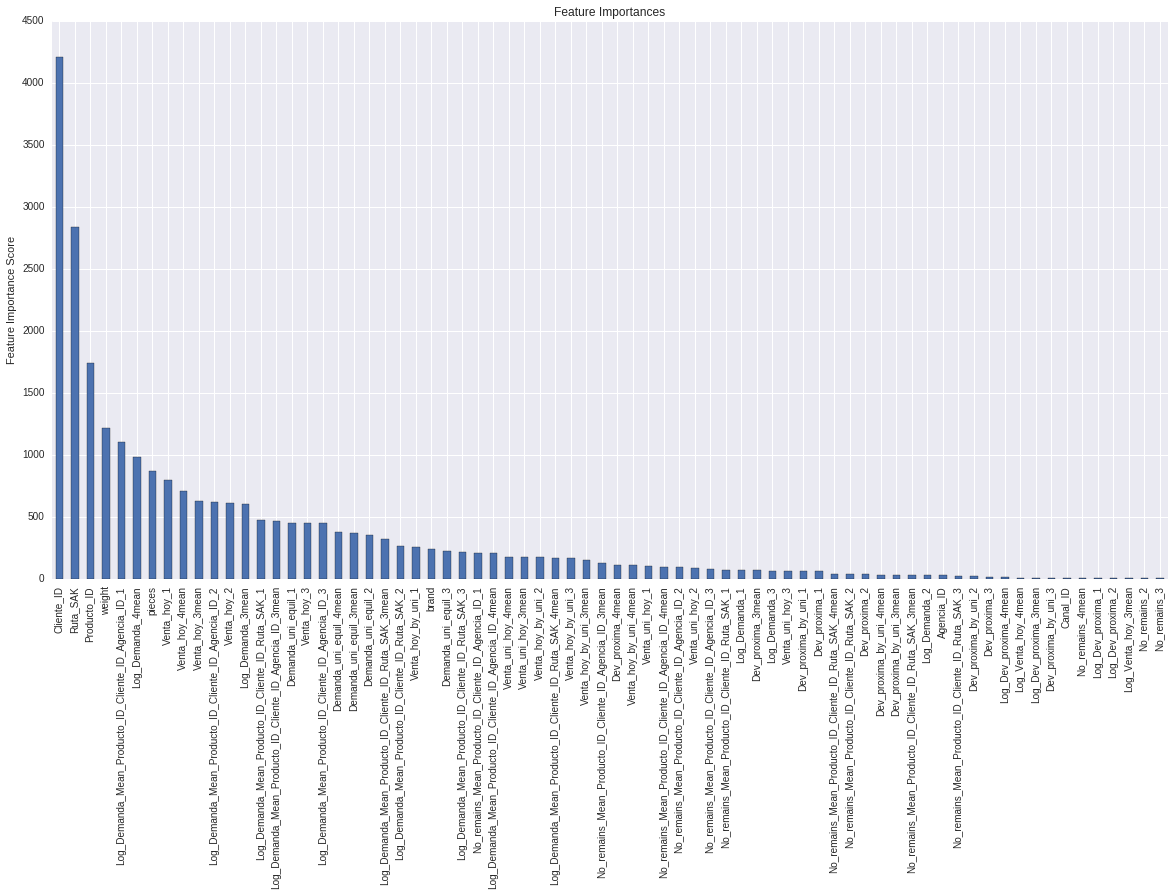

In [8]:
plot_feature_importances(xgb_model_week8)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model_week8.predict(X_train_week8))))
print('Test:', np.sqrt(mean_squared_error(y_test_week8,
                                          xgb_model_week8.predict(X_test_week8))))

In [9]:
feat_imp_week10 = pd.Series(xgb_model_week8.booster().get_fscore()).sort_values(ascending=False)
#feat_imp_week10.to_csv('feat_imp_week10_xgboost_release_v02.csv')

# Next week prediction

In [10]:
param = {
 'learning_rate': 0.3,
 'gamma': 0,
 'max_depth': 10,
 'min_child_weight': 24,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model_week9 = xgb.XGBRegressor()
xgb_model_week9.set_params(**param)

xgb_model_week9.fit(X_train_week9, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=10,
       min_child_weight=24, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.357243131128
Test: 0.363191807671


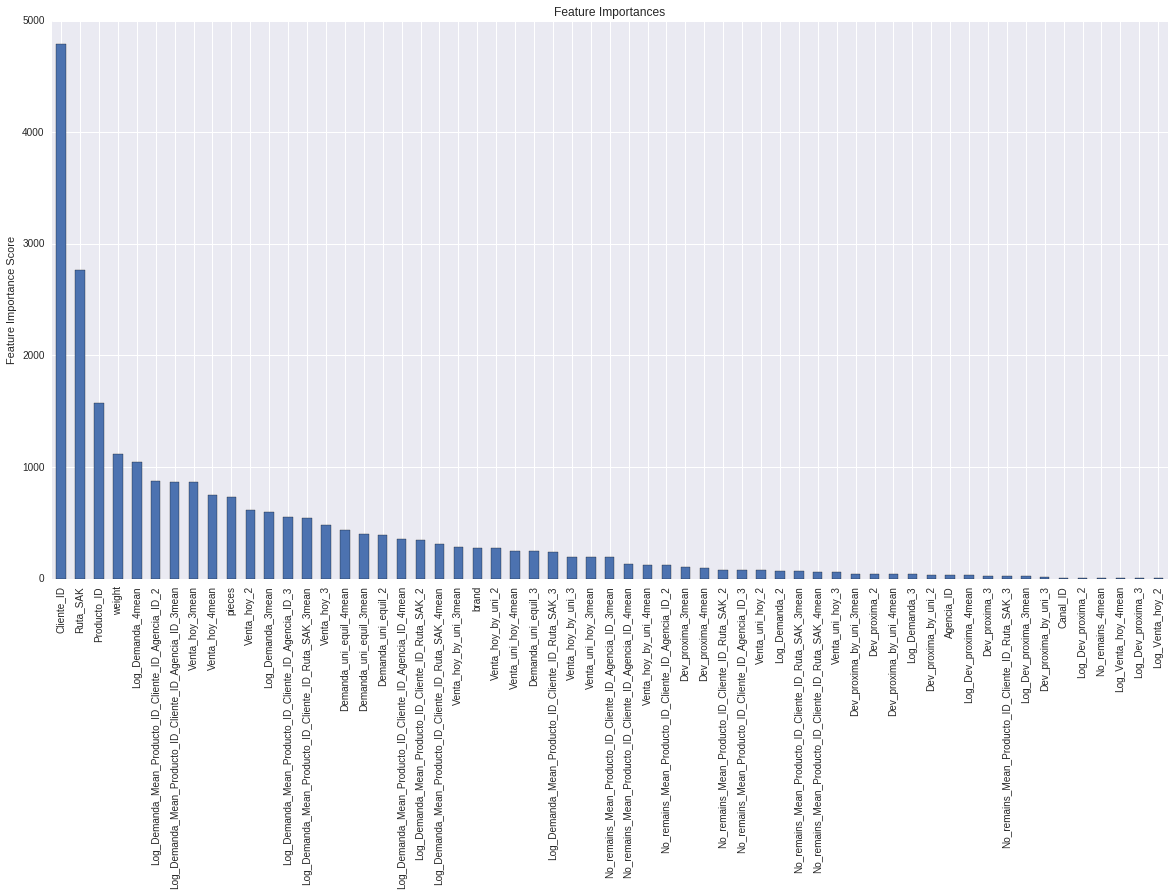

In [11]:
plot_feature_importances(xgb_model_week9)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model_week9.predict(X_train_week9))))
print('Test:', np.sqrt(mean_squared_error(y_test_week9,
                                          xgb_model_week9.predict(X_test_week9))))

In [12]:
feat_imp_week11 = pd.Series(xgb_model_week9.booster().get_fscore()).sort_values(ascending=False)
#feat_imp_week11.to_csv('feat_imp_week11_xgboost_release_v02.csv')

# Cross-validation

In [ ]:
param = {
 'learning_rate': 0.2,
 'gamma': 0,
 'max_depth': 10,
 'min_child_weight': 22,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgtrain = xgb.DMatrix(X_train_week8.values, label=y_train.values)
cvresult = xgb.cv(param, xgtrain, num_boost_round=200, nfold=5,
                    metrics='rmse', early_stopping_rounds=10)
cvresult

In [ ]:
cvresult[80:120]

In [ ]:
grid_param = {
 'max_depth': [15, 17, 20, 23, 25],
 'min_child_weight': [5, 8, 10, 12],
}

xgb_model = xgb.XGBRegressor(n_estimators=78,
                             learning_rate = 0.3,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8)

clf = GridSearchCV(xgb_model, grid_param, cv=5,
                   scoring='mean_squared_error',verbose=1, n_jobs=-1)
clf.fit(X_train_week8, y_train)

print(clf.best_score_)
print(clf.best_params_)
clf.grid_scores_

In [ ]:
plot_feature_importances(clf.best_estimator_)

# Grid search without cross-validation

In [ ]:
from gridsearch import GridSearch

### Week 8

In [ ]:
param_grid = {
    'gamma': [0]
}

xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate = 0.3,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             max_depth=10,
                             min_child_weight=22)

gs = GridSearch(xgb_model, param_grid, verbose=1)
    
gs.fit(X_train_week8, X_test_week8, y_train, y_test_week8)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

### Week 9

In [ ]:
param_grid = {
    'max_depth':[7, 10, 13],
    'min_child_weight': [19, 22, 25]   
}

xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate = 0.3,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             gamma=0)

gs = GridSearch(xgb_model, param_grid, verbose=1)
    
gs.fit(X_train_week9, X_test_week9, y_train, y_test_week9)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

# XGBoost GridSearch Experiment

In [6]:
from xgboost_grid_search_experiment import XGBoostGridSearchExperiment

In [7]:
default_param = {
 'learning_rate': 0.3,
 'gamma': 0,
 'max_depth': 10,
 'min_child_weight': 22,
 'n_estimators': 1,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

tuning_parameters = [
    {
        'max_depth':[7, 10, 13], 
        'min_child_weight': [19, 22, 25] 
    },
    {
        'gamma': [0, 1, 2]
    }
]

gs_week8, gs_week9 = XGBoostGridSearchExperiment(data, 'new_test',
                                                 default_param, tuning_parameters, weeks='all')

Default parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'min_child_weight': 22, 'n_estimators': 1, 'subsample': 0.8, 'max_depth': 10, 'gamma': 0}
Tuning parameters:
{'max_depth': [7, 10, 13], 'min_child_weight': [19, 22, 25]}
{'gamma': [0, 1, 2]}

Stage 0
Tuning parameters: {'max_depth': [7, 10, 13], 'min_child_weight': [19, 22, 25]}
Week 8
Fitting 9 candidates
0 test score: 1.016147, train score: 1.011450, params: {'max_depth': 7, 'min_child_weight': 19}
1 test score: 1.016137, train score: 1.011456, params: {'max_depth': 7, 'min_child_weight': 22}
2 test score: 1.016126, train score: 1.011457, params: {'max_depth': 7, 'min_child_weight': 25}
3 test score: 1.009884, train score: 1.006143, params: {'max_depth': 10, 'min_child_weight': 19}
4 test score: 1.009860, train score: 1.006159, params: {'max_depth': 10, 'min_child_weight': 22}
5 test score: 1.009833, train score: 1.006189, params: {'max_depth': 10, 'min_child_weight': 25}
6 test score: 1.008577, train score: 1.003231

In [9]:
gs_week8.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=2, learning_rate=0.3, max_delta_step=0, max_depth=13,
       min_child_weight=19, missing=None, n_estimators=1, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [10]:
gs_week9.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=2, learning_rate=0.3, max_delta_step=0, max_depth=13,
       min_child_weight=19, missing=None, n_estimators=1, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)